In [4]:
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


#you need the pima_indians.csv to run

#label data

filename = 'FeatureSelectionOutput.csv'


#read data
data = read_csv(filename)
array = data.values
X = array[:,0:-1]
y = array[:,-1]



# split data and train model
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)
svm = SVC(kernel='rbf', random_state=0, gamma=1, C=1, probability = True)
df = pd.DataFrame(y_test, columns = ['label'])



# fit model
svm.fit(X_train, y_train)

# make class predictions for the testing set
y_pred_class = svm.predict(X_test)
y_pred_prob = svm.predict_proba(X_test)[:, 1]

#pass true and predicted values into dataframe
#df = y_test.to_frame().reset_index()
df['predicted'] = y_pred_class
df['probabilty'] = y_pred_prob
#df.shape()

#if you want to check data has read in correctly:
df.head()

#to test function:
#model_evaluator(df)


,label,predicted,probabilty
0,0.0,0.0,2.730444e-03
1,0.0,0.0,2.730444e-03
2,0.0,0.0,1.000000e-07
3,0.0,0.0,2.730444e-03
4,0.0,0.0,2.730444e-03


In [5]:

type(y_test)


numpy.ndarray

In [7]:
import numpy as np
import pandas as pd
from pandas import read_csv
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import classification_report
from matplotlib.ticker import FixedLocator, FixedFormatter


##Evaluates the performance of a binary classifier against labelled data.
# @param data - a dataframe containing 3 columns: class (binary values), predicted(binary values) and 
#probability (the predicition the model has made for each value, prior to converting to a binary classification, number between 0 and 1).
# @returns - Confusion matrix plot, ROC curve plot, and a small report.

def model_evaluator(data):
    
    #partition processed data into vectors
    actualClass = data.label
    predictedClass = data.predicted
    probability = data.probabilty 
    
    #build a confusion matrix
    cm = confusion_matrix(actualClass, predictedClass, labels = [0,1])
    
    
    TruePositive = cm[1, 1]
    TrueNegative = cm[0,0]
    FalsePositive = cm[0,1]
    FalseNegative = cm[1,0]
    
    numberOfPositives = TruePositive + FalseNegative
    numberOfNegatives = TrueNegative + FalsePositive
    
    #calculate the Null accuracy
    null_accuracy = 1 - actualClass.mean()
    
    #define the model accuracy
    model_accuracy = metrics.accuracy_score(actualClass, predictedClass)
    
    #Generate a metrics report
    report = metrics.classification_report(actualClass, predictedClass, output_dict = True)
  
    #calculate the model performance over the null accuracy
    performance_over_null = model_accuracy - null_accuracy
    
    #Calculate the Specificity of the model 
    specificity = TrueNegative / (TrueNegative + FalsePositive)
    
    #Calculate the True positive rate, false positive rate, and thresholds to plot a rock curve
    fpr, tpr, thresholds = metrics.roc_curve(actualClass, probability)
    
    #Calculate the Area under the ROC Curve
    rocAuc = metrics.roc_auc_score(actualClass, probability)
    
    #generate figure
    fig = plt.figure(figsize = (12, 20))
    spec = gridspec.GridSpec(ncols=2, nrows=1, wspace=0.5, width_ratios=[1, 1], figure=fig)
    
    #plot confusion matrix in pos 0,0
    confusionMatrixLabels = ['Normal Traffic', 'Intrusion']
    confusionMatrixColourMap = plt.cm.Blues
    confusionMatrix = fig.add_subplot(spec[0,0])
    confusionMatrix.set_aspect('equal')
    confusionMatrix.imshow(cm, interpolation = 'nearest', cmap = confusionMatrixColourMap)
    confusionMatrix.set(ylabel ='True class', xlabel ='Predicted class')
    #confusionMatrix.xlabel(labelpad=5)
            
    confusionMatrix.set_xticks(np.arange(0,2))
    formatter = FixedFormatter(['Normal Traffic', 'Intrusion'])
    locator = FixedLocator([0,1])
    
    confusionMatrix.yaxis.set_major_formatter(formatter)
    confusionMatrix.yaxis.set_major_locator(locator)
    confusionMatrix.xaxis.set_major_formatter(formatter)
    confusionMatrix.xaxis.set_major_locator(locator)
    
    #confusionMatrix.set_yticks(np.arange(0,2))
    #confusionMatrix.set_xticklabels(np.arange(0,1), confusionMatrixLabels, fontdict = None)
    
    tot = sum(df.label)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            confusionMatrix.text(j, i, (format(cm[i, j])),ha ='center', va="baseline", color="white" if cm[i,j] > tot else 'black', size = 'larger')
    
   
    cmLabels = ['TN', 'FP', 'FN', 'TP' ]
    a = 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            confusionMatrix.text(j + 0.3, i + 0.4, (cmLabels[a]), ha ='center', va="baseline", color="white" if cm[i,j] > tot else 'black', size = 'larger')
            if a < 4:
                a += 1
    a=0          
    for i in range(cm.shape[a]):
        if a == 0:
            confusionMatrix.text(j+0.8, i, ('Total:\n %d' % (numberOfNegatives)), ha ='center', va="center", color = 'black', size = 'larger')
            a += 1
        else:
            confusionMatrix.text(j+0.8, i, ('Total:\n %d' % (numberOfPositives)), ha ='center', va="center", color = 'black', size = 'larger')
    
    #plot roc curve in position 0,1 
    rocCurve = fig.add_subplot(spec[0, 1])
    rocCurve.set_aspect('equal')
    rocCurve.plot(fpr, tpr, color='red', lw=2, label = 'ROC area = %0.5f)' % rocAuc )
    rocCurve.set(xlabel = 'True Positive Rate (Sensitivity)', ylabel = 'True Positive Rate (Sensitivity)' )
    rocCurve.legend(loc="lower right")
    
    
    #print report
    print('The performance of this model over the null accuracy is %2.2f%%\nModel Sensitivity: %2.6f%% \nModel Specificity: %2.6f%% \nModel F1 Score: %2.6f' 
      % ((performance_over_null *100), (report['1']['recall']*100), (specificity*100), (report['1']['f1-score'])))


KeyError: '1'

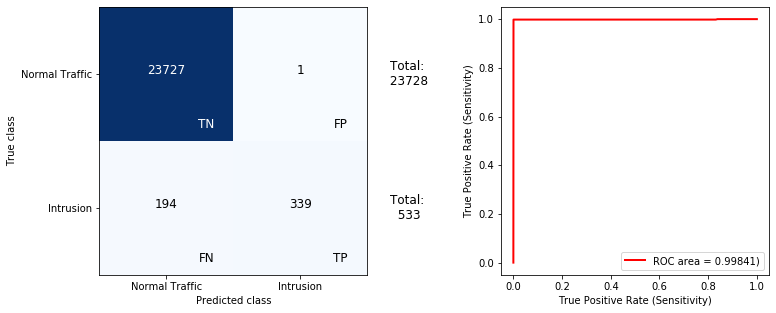

In [8]:
model_evaluator(df)